# TREINAMENTO REDE EFFICIENTNET v3.2EF.30e.2Sl

**Rede:** Efficient Net

> Com os pesos congelados

**Dataset:** Selected Localized

> Epochs = 30

> Batch = 32

> Target = (100, 100)

> SEED = 10

> CLUSTERIZAÇÃO? Não

**Obs.:** Com separação de indivíduo

In [1]:
!nvidia-smi

Wed Sep 25 13:05:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['TF_DISABLE_JIT'] = '1'

In [3]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=1.0e10

[I 13:05:57.749 NotebookApp] [nb_conda_kernels] enabled, 1 kernels found
[I 13:05:57.835 NotebookApp] Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html

Please note that updating to Notebook 7 might break some of your extensions.

[I 13:05:58.212 NotebookApp] Registered dataproc_jupyter_plugin server extension
jupyter_http_over_ws extension initialized. Listening on /http_over_websocket
[I 13:05:58.609 NotebookApp] Skipped non-installed server(s): bash-language-server, dockerfile-language-server-nodejs, javascript-typescript-langserver, jedi-language-server, julia-language-server, pyr

## Bibliotecas e Constantes

In [4]:
#!pip install tensorflow[and-cuda]

In [5]:
!pip install efficientnet

!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.1 MB/s eta 0:00:00


In [6]:
#------------------------------------------------------------------------------
# BIBLIOTECAS

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random

# BIBLIOTECAS DEEP LEARNING
import datetime
import tensorflow as tf
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image
#from tf_keras_vis.gradcam import Gradcam
#from tf_keras_vis.utils.scores import CategoricalScore
#from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

from efficientnet.tfkeras import EfficientNetB7

#------------------------------------------------------------------------------
# CONSTANTES

DATASET_TYPE = ['cleaned', 'selected', 'selected-localized', 'cleaned-localized']
DATASET_TYPE = DATASET_TYPE[3] # Dataset utilizado no treinamento

DATASET_COMPLETO = True

CNN_MODEL = 'efficient-net' # Rede utilizada no treinamento

SEED = 10
np.random.seed(SEED) # semente geradora dos numeros aleatorios
random.seed(SEED)
tf.random.set_seed(SEED)

N_FOLDS = 5
N_EPOCHS = 30
BATCH_SIZE = 32
SIZE = 100
TARGET_SIZE = (SIZE, SIZE)

VERSION = '2.1EF.30e.2SL'

2024-09-25 13:06:31.541497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 13:06:31.541620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 13:06:31.684147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Diretórios e Carregamentos de Dados

In [7]:
# Criando pasta de resultados
if not os.path.exists(f'{DATASET_TYPE}'):
    os.mkdir(f'{DATASET_TYPE}')

In [8]:
#------------------------------------------------------------------------------
# DIRETÓRIOS DOS DATASETS

DATASET_PATH = f'/kaggle/input/myocardit-dataset-cleaned-localized'
RESULTS_PATH = f'/kaggle/working/{DATASET_TYPE}'

NORMAL_PATH = DATASET_PATH + '/Normal/'
SICK_PATH = DATASET_PATH + '/Sick/'

# Diretorios de cada Individuo:
normal_datasets = [f'{NORMAL_PATH}Individuo_{i:02}/' for i in range(1, 17)]
sick_datasets = [f'{SICK_PATH}Individuo_{i:02}/' for i in range(17, 48)]

print(normal_datasets)
print(sick_datasets)

NORMAL_SPLITS = [[9, 10, 12, 15],
                 [1,8,11],
                 [4,5,14],
                 [2,7,13],
                 [3,6,16]]

if DATASET_COMPLETO == True:
    SICK_SPLITS = [[21,23,26,27,36,38],
                   [18,37,39,40,41,45,46],
                   [20,24,28,29,31,32],
                   [19,22,30,33,42,47],
                   [17,25,34,35,43,44]]

normal_splits = [[],[],[],[],[]]
sick_splits = [[],[],[],[],[]]

for split in range(N_FOLDS):
    normal_splits[split].extend(normal_datasets[i-1] for i in NORMAL_SPLITS[split])
    sick_splits[split].extend(sick_datasets[i-17] for i in SICK_SPLITS[split])

['/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_01/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_02/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_03/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_04/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_05/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_06/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_07/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_08/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_09/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_10/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_11/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_12/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_13/', '/kaggle/input/myocardit-dataset-clea

In [9]:
#------------------------------------------------------------------------------
# CARREGAMENTO DE DADOS COM SEPARAÇÃO DE INDIVIDUOS

print('\nIniciando carregamento e processamento das imagens..............!')

def carregar_imagens(diretorio):
    global num_imagens
    imagens = []
    for pasta_atual, subpastas, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.endswith(('.jpg', '.jpeg', '.png')):
                caminho = os.path.join(pasta_atual, arquivo)
                
                img = Image.open(caminho)
                img = img.resize(TARGET_SIZE)
                img = img.convert('L')
                img_array = np.array(img)
                imagens.append(img_array)
                
                num_imagens += 1
                sys.stdout.write("\rNumero de imagens carregados: %i" % num_imagens)
                sys.stdout.flush()
                
    return imagens

num_imagens = 0

print('\nPacientes normais:')
normal_groups = []
for diretorios in normal_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    normal_groups.append(imagens)

num_imagens = 0

print('\n\nPacientes doentes:')
sick_groups = []
for diretorios in sick_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    sick_groups.append(imagens)

# DATASETS SEPRADAOS EM 5 PARA VALIDAÇÃO CRUZADA    
x_data = [[],[],[],[],[]]
y_data = [[],[],[],[],[]]

print('\n\nNumero de imagens por split:')
for i in range(N_FOLDS):
    x_data[i].extend(path for path in normal_groups[i])
    y_data[i].extend([1, 0] for path in normal_groups[i])
    x_data[i].extend(path for path in sick_groups[i])
    y_data[i].extend([0, 1] for path in sick_groups[i])
    print(f'Split {i+1}: {len(x_data[i])} imagens ({len(normal_groups[i])} saudáveis e {len(sick_groups[i])} doentes).')


Iniciando carregamento e processamento das imagens..............!

Pacientes normais:
Numero de imagens carregados: 6675

Pacientes doentes:
Numero de imagens carregados: 3477

Numero de imagens por split:
Split 1: 2056 imagens (1134 saudáveis e 922 doentes).
Split 2: 1969 imagens (1645 saudáveis e 324 doentes).
Split 3: 2320 imagens (1339 saudáveis e 981 doentes).
Split 4: 2104 imagens (1395 saudáveis e 709 doentes).
Split 5: 1703 imagens (1162 saudáveis e 541 doentes).


## Treinamento

In [10]:
# Arquitetura CNN
def cnn_model(input_shape, num_classes):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [11]:
#------------------------------------------------------------------------------
# SEPARAÇÃO DE DADOS E TREINAMENTO

lst_accuracy=[]
lst_accuracy_v=[]
lst_accuracy_train=[]
lst_acc=[]
lst_loss=[]
lst_reports=[]
lst_AUC=[]
lst_matrix=[]
lst_matrix_v=[]
lst_matrix_train=[]
lst_times=[]
lst_history=[]

#------------------------------------------------------------------------------
# TREINAMENTO POR FOLDS

for fold in range(N_FOLDS):

    print(f'\n\nFOLD {fold+1}:')

    #--------------------------------------------------------------------------
    # CARREGAMENTO DAS IMAGENS DE TREINAMENTO, VALIDACAO E TESTE

    print(f'\nCarregamento das imagens do fold {fold+1} para treinamento.............!')

    folds = [0, 1, 2, 3, 4]

    x_test = np.array(x_data[fold])
    y_test = np.array(y_data[fold])
    folds.remove(fold)

    x_valid = np.array(x_data[folds[0]])
    y_valid = np.array(y_data[folds[0]])
    folds.remove(folds[0])

    x_train, y_train = [], []
    for i in folds:
        x_train.extend(x_data[i])
        y_train.extend(y_data[i])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_train = np.stack([x_train] * 3, axis=-1)
    x_valid = np.stack([x_valid] * 3, axis=-1)
    x_test = np.stack([x_test] * 3, axis=-1)
    
    print(f'Numero de imagens no treinamento: {len(x_train)} imagens.')
    print(f'Numero de imagens na validação: {len(x_valid)} imagens.')
    print(f'Numero de imagens no teste: {len(x_test)} imagens.')

    #--------------------------------------------------------------------------
    # ARQUITETURA E COMPILACAO

    model=cnn_model((SIZE, SIZE, 3), 2)
    
    OPTIMIZER = AdamW(weight_decay = 0.004)
    
    # Compilacao do modelo
    model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['categorical_accuracy'])

    #--------------------------------------------------------------------------
    # TREINAMENTO
    print('\nIniciando o treinamento.........................................!\n')

    calback=CSVLogger(RESULTS_PATH + f'/logger_fold{fold+1}.log')

    # Treinando o modelo
    start=datetime.datetime.now()

    history=model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_valid, y_valid), callbacks=[calback])

    end=datetime.datetime.now()
    training_time=end-start

    # Salvamento do modelo
    model.save(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.h5')

    #--------------------------------------------------------------------------
    # TESTE

    # Testando o modelo
    print("\nTestando imagens................................................!\n")

    # Acuracia e Perda do Teste
    test_loss, test_acc = model.evaluate(x_test, y_test)

    print(model.metrics_names)

    #--------------------------------------------------------------------------
    # ARMAZENAMENTO DOS INFORMACOES

    # Fazendo previsões
    predicts = model.predict(x_test)
    predicts = predicts.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals=y_test.argmax(axis=1)

    # Calculando a curva ROC
    fpr, tpr, _ = roc_curve(actuals, predicts, pos_label=1)
    a = auc(fpr, tpr)

    # Gerando o relatório de classificação
    r = classification_report(actuals, predicts, zero_division=1)

    # Calculando a matriz de confusão
    c = confusion_matrix(actuals, predicts)
    accuracy = np.trace(c)/np.sum(c)
    
    # Validação
    # Fazendo previsões
    predicts_v = model.predict(x_valid)
    predicts_v = predicts_v.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_v=y_valid.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_v = confusion_matrix(actuals_v, predicts_v)
    accuracy_v = np.trace(c_v)/np.sum(c_v)
    
    # Treino
    # Fazendo previsões
    predicts_train = model.predict(x_train)
    predicts_train = predicts_train.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_train=y_train.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_train = confusion_matrix(actuals_train, predicts_train)
    accuracy_train = np.trace(c_train)/np.sum(c_train)

    lst_history.append(history)
    lst_times.append(training_time)
    lst_accuracy.append(accuracy)
    lst_acc.append(test_acc)
    lst_loss.append(test_loss)
    lst_AUC.append(a)
    lst_reports.append(r)
    lst_matrix.append(c)
    
    lst_accuracy_v.append(accuracy_v)
    lst_matrix_v.append(c_v)
    
    lst_accuracy_train.append(accuracy_train)
    lst_matrix_train.append(c_train)



FOLD 1:

Carregamento das imagens do fold 1 para treinamento.............!
Numero de imagens no treinamento: 6127 imagens.
Numero de imagens na validação: 1969 imagens.
Numero de imagens no teste: 2056 imagens.
258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  1/192 ━━━━━━━━━━━━━━━━━━━━ 6:40:54 126s/step - categorical_accuracy: 0.4062 - loss: 649.3109

I0000 00:00:1727269786.643461     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1727269786.811562     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - categorical_accuracy: 0.5249 - loss: 324.5328

W0000 00:00:1727269906.719299     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/192 ━━━━━━━━━━━━━━━━━━━━ 264s 720ms/step - categorical_accuracy: 0.5251 - loss: 323.4177 - val_categorical_accuracy: 0.8192 - val_loss: 0.7125
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - categorical_accuracy: 0.6228 - loss: 1.1370 - val_categorical_accuracy: 0.8075 - val_loss: 0.6810
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - categorical_accuracy: 0.6286 - loss: 0.9873 - val_categorical_accuracy: 0.8258 - val_loss: 0.6424
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - categorical_accuracy: 0.6266 - loss: 0.7650 - val_categorical_accuracy: 0.8334 - val_loss: 0.5680
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - categorical_accuracy: 0.6265 - loss: 0.8627 - val_categorical_accuracy: 0.8309 - val_loss: 0.5882
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - categorical_accuracy: 0.6254 - loss: 0.9256 - val_categorical_accuracy: 0.8349 - val_loss: 0.5643
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - categorical_accuracy: 0.628

W0000 00:00:1727270501.693067     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 295ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step


FOLD 2:

Carregamento das imagens do fold 2 para treinamento.............!
Numero de imagens no treinamento: 6127 imagens.
Numero de imagens na validação: 2056 imagens.
Numero de imagens no teste: 1969 imagens.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  3/192 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - categorical_accuracy: 0.5417 - loss: 462.6186 

W0000 00:00:1727270676.620287     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - categorical_accuracy: 0.5583 - loss: 337.0825

W0000 00:00:1727270796.909973     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/192 ━━━━━━━━━━━━━━━━━━━━ 250s 690ms/step - categorical_accuracy: 0.5585 - loss: 336.0396 - val_categorical_accuracy: 0.5472 - val_loss: 0.8304
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - categorical_accuracy: 0.6235 - loss: 1.7328 - val_categorical_accuracy: 0.5029 - val_loss: 0.7975
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - categorical_accuracy: 0.6251 - loss: 0.7862 - val_categorical_accuracy: 0.5482 - val_loss: 0.7240
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - categorical_accuracy: 0.6252 - loss: 0.9244 - val_categorical_accuracy: 0.5486 - val_loss: 0.7123
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - categorical_accuracy: 0.6274 - loss: 0.7109 - val_categorical_accuracy: 0.5467 - val_loss: 0.7636
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - categorical_accuracy: 0.6291 - loss: 0.8774 - val_categorical_accuracy: 0.5540 - val_loss: 0.7115
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - categorical_accuracy: 0.626

W0000 00:00:1727271352.805573     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 303ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step


FOLD 3:

Carregamento das imagens do fold 3 para treinamento.............!
Numero de imagens no treinamento: 5776 imagens.
Numero de imagens na validação: 2056 imagens.
Numero de imagens no teste: 2320 imagens.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  3/181 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - categorical_accuracy: 0.5122 - loss: 65.5600 

W0000 00:00:1727271530.465904     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - categorical_accuracy: 0.6040 - loss: 273.8206

W0000 00:00:1727271667.408977     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/181 ━━━━━━━━━━━━━━━━━━━━ 272s 830ms/step - categorical_accuracy: 0.6042 - loss: 273.0617 - val_categorical_accuracy: 0.5525 - val_loss: 0.7429
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - categorical_accuracy: 0.7041 - loss: 6.4513 - val_categorical_accuracy: 0.5520 - val_loss: 0.7848
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - categorical_accuracy: 0.7136 - loss: 1.0527 - val_categorical_accuracy: 0.5516 - val_loss: 0.7760
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - categorical_accuracy: 0.7127 - loss: 2.2882 - val_categorical_accuracy: 0.5525 - val_loss: 0.8648
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - categorical_accuracy: 0.7098 - loss: 22.1117 - val_categorical_accuracy: 0.5516 - val_loss: 0.8737
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - categorical_accuracy: 0.7171 - loss: 0.6192 - val_categorical_accuracy: 0.5511 - val_loss: 0.8104
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - categorical_accuracy: 0.71

W0000 00:00:1727272205.437260     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 265ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step


FOLD 4:

Carregamento das imagens do fold 4 para treinamento.............!
Numero de imagens no treinamento: 5992 imagens.
Numero de imagens na validação: 2056 imagens.
Numero de imagens no teste: 2104 imagens.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  3/188 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - categorical_accuracy: 0.6354 - loss: 71.5716 

W0000 00:00:1727272370.692565     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - categorical_accuracy: 0.6043 - loss: 211.8174

W0000 00:00:1727272486.416576     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 245s 686ms/step - categorical_accuracy: 0.6045 - loss: 211.1743 - val_categorical_accuracy: 0.5467 - val_loss: 0.8336
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - categorical_accuracy: 0.6824 - loss: 0.8422 - val_categorical_accuracy: 0.5447 - val_loss: 0.7539
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - categorical_accuracy: 0.6881 - loss: 1.1293 - val_categorical_accuracy: 0.5506 - val_loss: 0.7530
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - categorical_accuracy: 0.6862 - loss: 1.1313 - val_categorical_accuracy: 0.5467 - val_loss: 0.7697
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - categorical_accuracy: 0.6862 - loss: 0.7958 - val_categorical_accuracy: 0.5457 - val_loss: 0.7596
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - categorical_accuracy: 0.6876 - loss: 0.6658 - val_categorical_accuracy: 0.5467 - val_loss: 0.7469
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - categorical_accuracy: 0.688

W0000 00:00:1727273048.809721     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 286ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step


FOLD 5:

Carregamento das imagens do fold 5 para treinamento.............!
Numero de imagens no treinamento: 6393 imagens.
Numero de imagens na validação: 2056 imagens.
Numero de imagens no teste: 1703 imagens.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
  2/200 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - categorical_accuracy: 0.4531 - loss: 284.5327   

W0000 00:00:1727273216.240968     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - categorical_accuracy: 0.5603 - loss: 399.8095

W0000 00:00:1727273338.783082     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 253s 677ms/step - categorical_accuracy: 0.5605 - loss: 398.5414 - val_categorical_accuracy: 0.5511 - val_loss: 0.6967
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - categorical_accuracy: 0.6778 - loss: 1.2862 - val_categorical_accuracy: 0.5525 - val_loss: 0.7054
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - categorical_accuracy: 0.6787 - loss: 1.0618 - val_categorical_accuracy: 0.5525 - val_loss: 0.7264
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - categorical_accuracy: 0.6796 - loss: 0.7173 - val_categorical_accuracy: 0.5482 - val_loss: 0.8505
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - categorical_accuracy: 0.6790 - loss: 1.1623 - val_categorical_accuracy: 0.5506 - val_loss: 0.7450
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - categorical_accuracy: 0.6807 - loss: 0.7285 - val_categorical_accuracy: 0.5462 - val_loss: 0.8287
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - categorical_accuracy: 0.678

W0000 00:00:1727273919.796756     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 349ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step


## Salvamento de Dados

In [12]:
#--------------------------------------------------------------------------
# SALVAMENTO DOS DADOS

print('\nSalvando informações da rede......................................!')

path = RESULTS_PATH + f'/results-v{VERSION}.txt'
    
matrix_total = np.sum(lst_matrix, axis=0)
accuracy_total = np.trace(matrix_total)/np.sum(matrix_total)

matrix_total_v = np.sum(lst_matrix_v, axis=0)
accuracy_total_v = np.trace(matrix_total_v)/np.sum(matrix_total_v)

matrix_total_train = np.sum(lst_matrix_train, axis=0)
accuracy_total_train = np.trace(matrix_total_train)/np.sum(matrix_total_train)
    
losses=[]
val_losses=[]
accuracies=[]
val_accuracies=[]

for item in lst_history:
    
    history=item.history
    loss=history['loss']
    accuracy=history['categorical_accuracy']
    
    val_loss=history['val_loss']
    val_accuracy=history['val_categorical_accuracy']
    
    losses.append(sum(loss)/len(loss))
    accuracies.append(sum(accuracy)/len(accuracy))
    
    val_losses.append(sum(val_loss)/len(val_loss))
    val_accuracies.append(sum(val_accuracy)/len(val_accuracy))

f1=open(path,'w')
f1.write(f'TREINAMENTO v{VERSION}\n')

f1.write('\nTest Accuracias: '+str(lst_acc)+'\nTest Losses: '+str(lst_loss))
f1.write('\n\nTest Accuracies Mean: '+str(np.mean(lst_acc)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nValid Accuracies: '+str(val_accuracies)+'\nValid Losses: '+str(val_losses))
f1.write('\n\nValid Accuracies Mean: '+str(np.mean(val_accuracies)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\nAccuracies from Confusion Matrix: '+str(lst_accuracy))

f1.write('\n\nTotal Confusion Matrix: \n'+str(matrix_total)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix: '+str(accuracy_total))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Valid: \n'+str(matrix_total_v)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Valid: '+str(accuracy_total_v))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Train: \n'+str(matrix_total_train)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Train: '+str(accuracy_total_train))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nMetrics for all Folds: \n\n')
for i in range(len(lst_reports)):
    f1.write(str(lst_reports[i]))
    f1.write('\n\nTraining Time: '+str(lst_times[i])+'\nAUC: '+str(lst_AUC[i]))
    f1.write('\n\nAcurácia: ' + str(lst_accuracy[i]))
    f1.write('\n\nMatriz de Confusao: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')
f1.close()


Salvando informações da rede......................................!


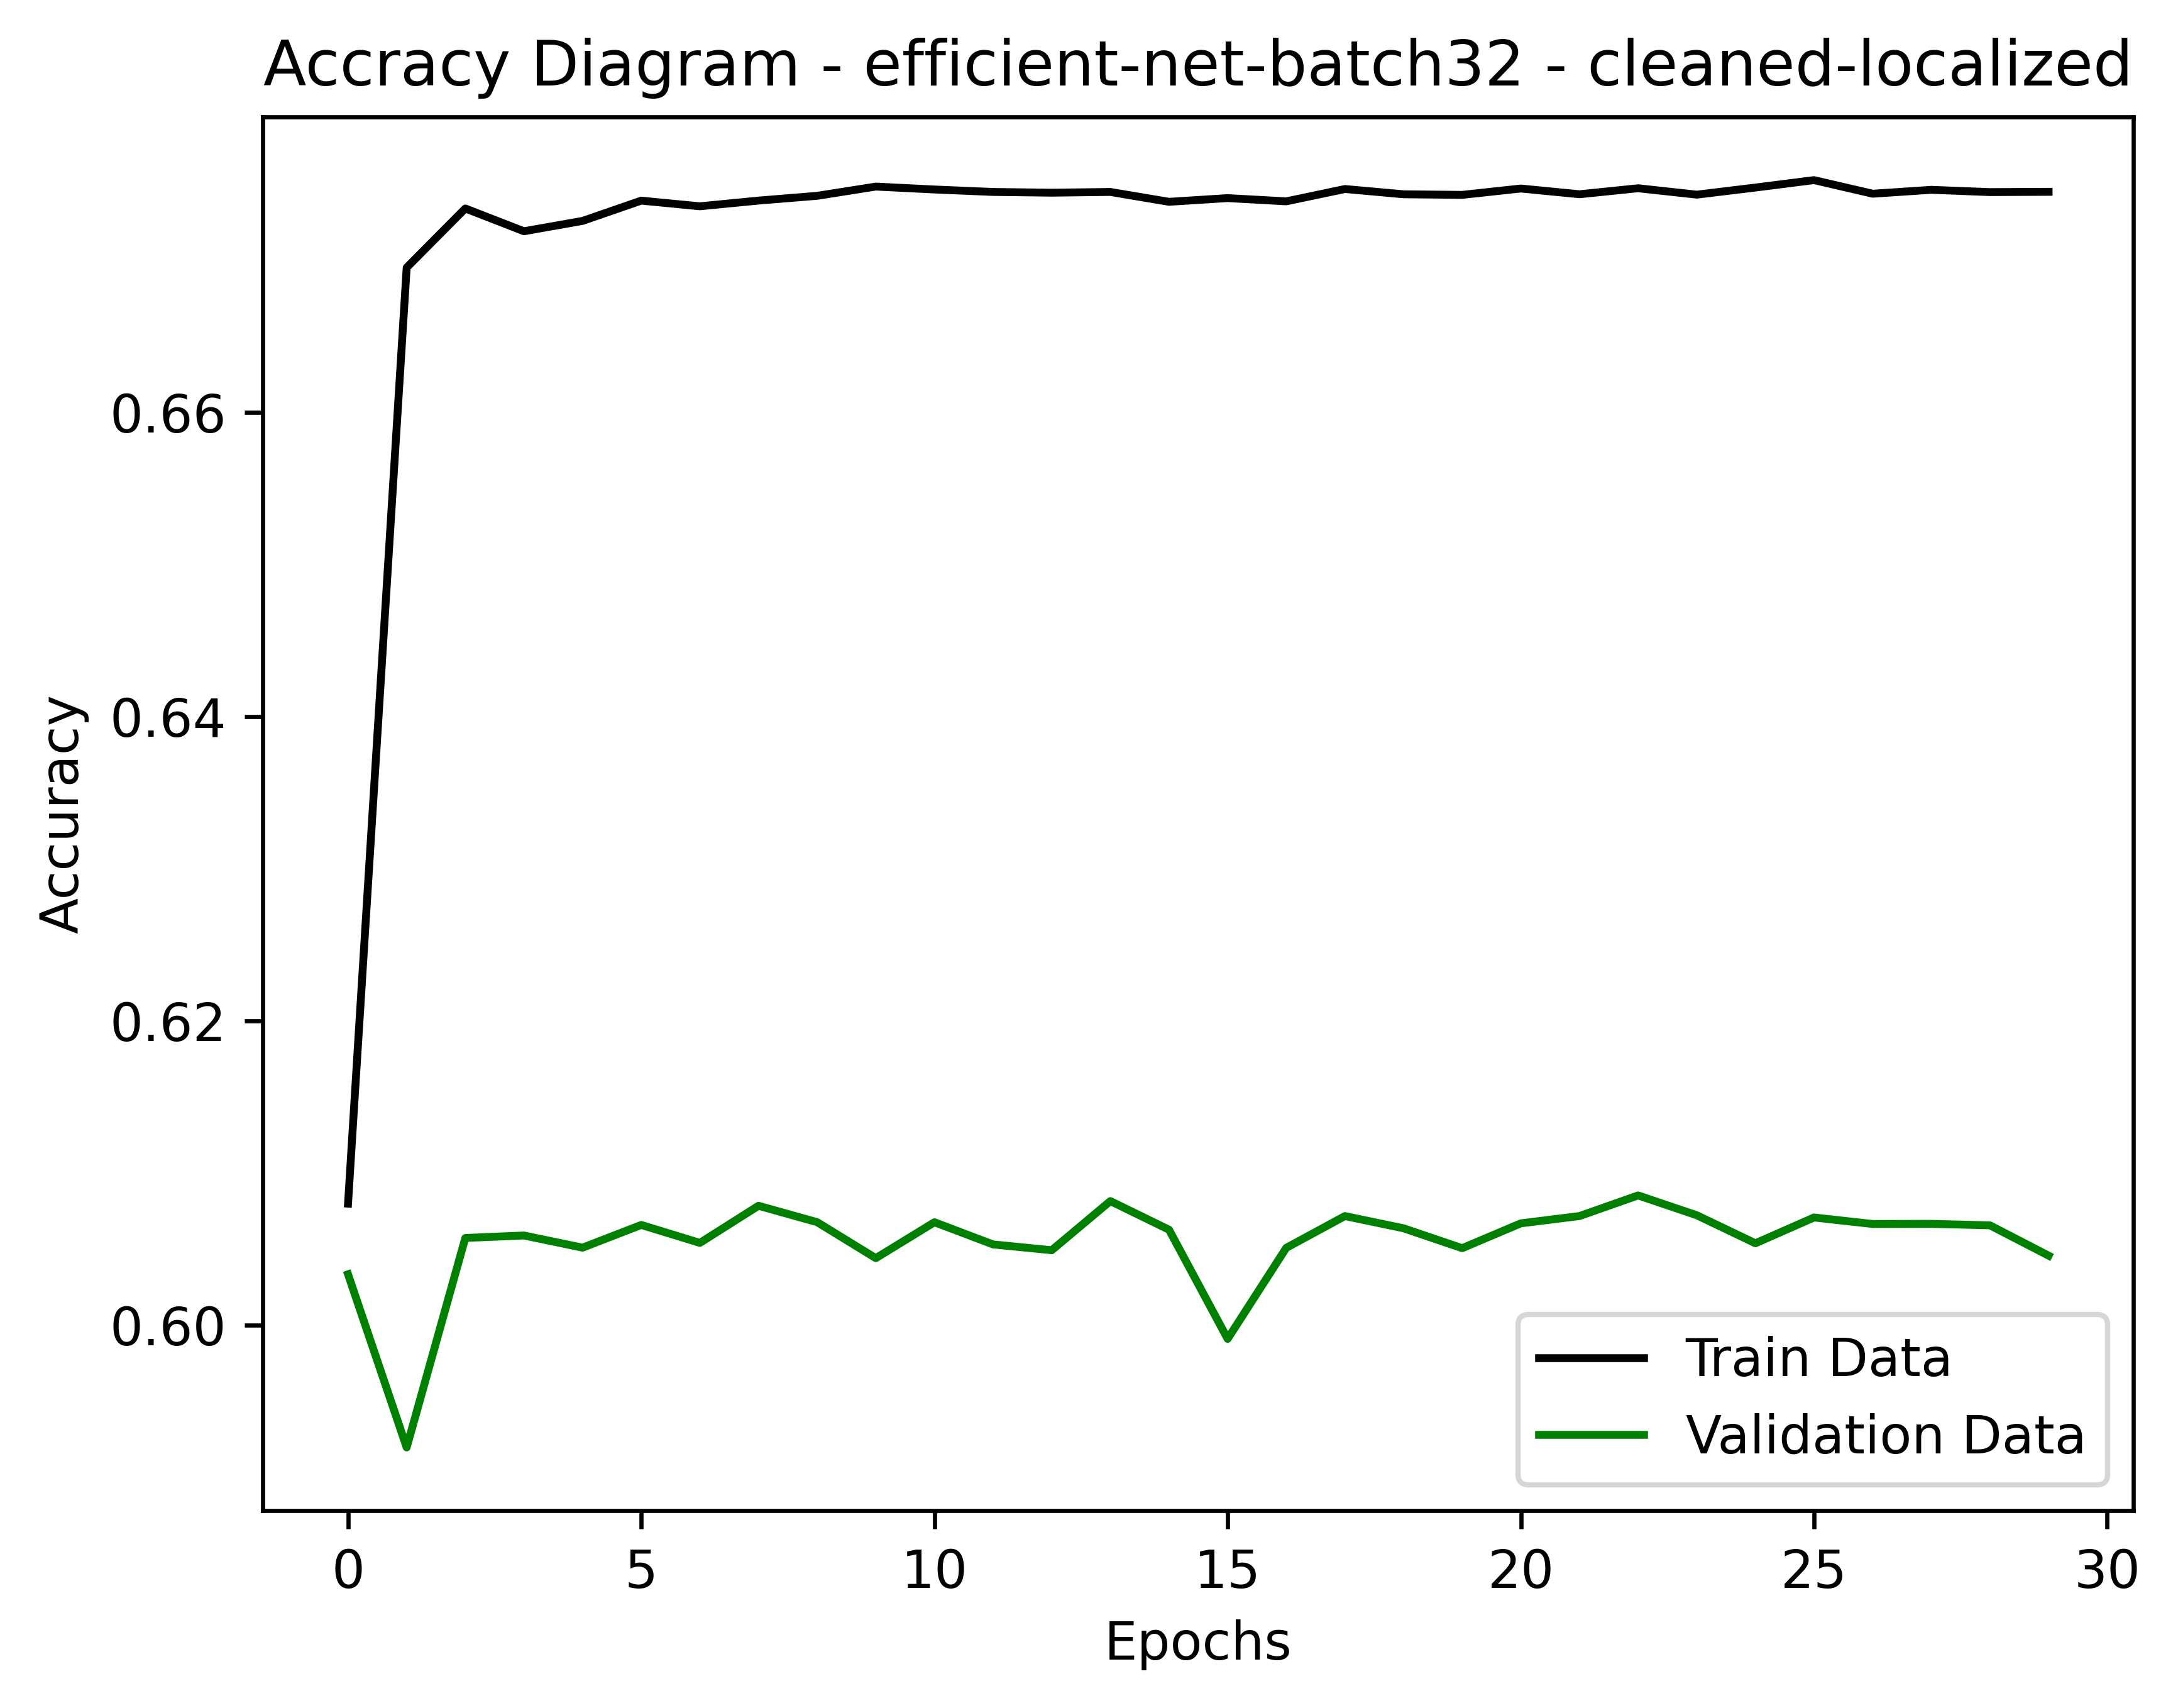

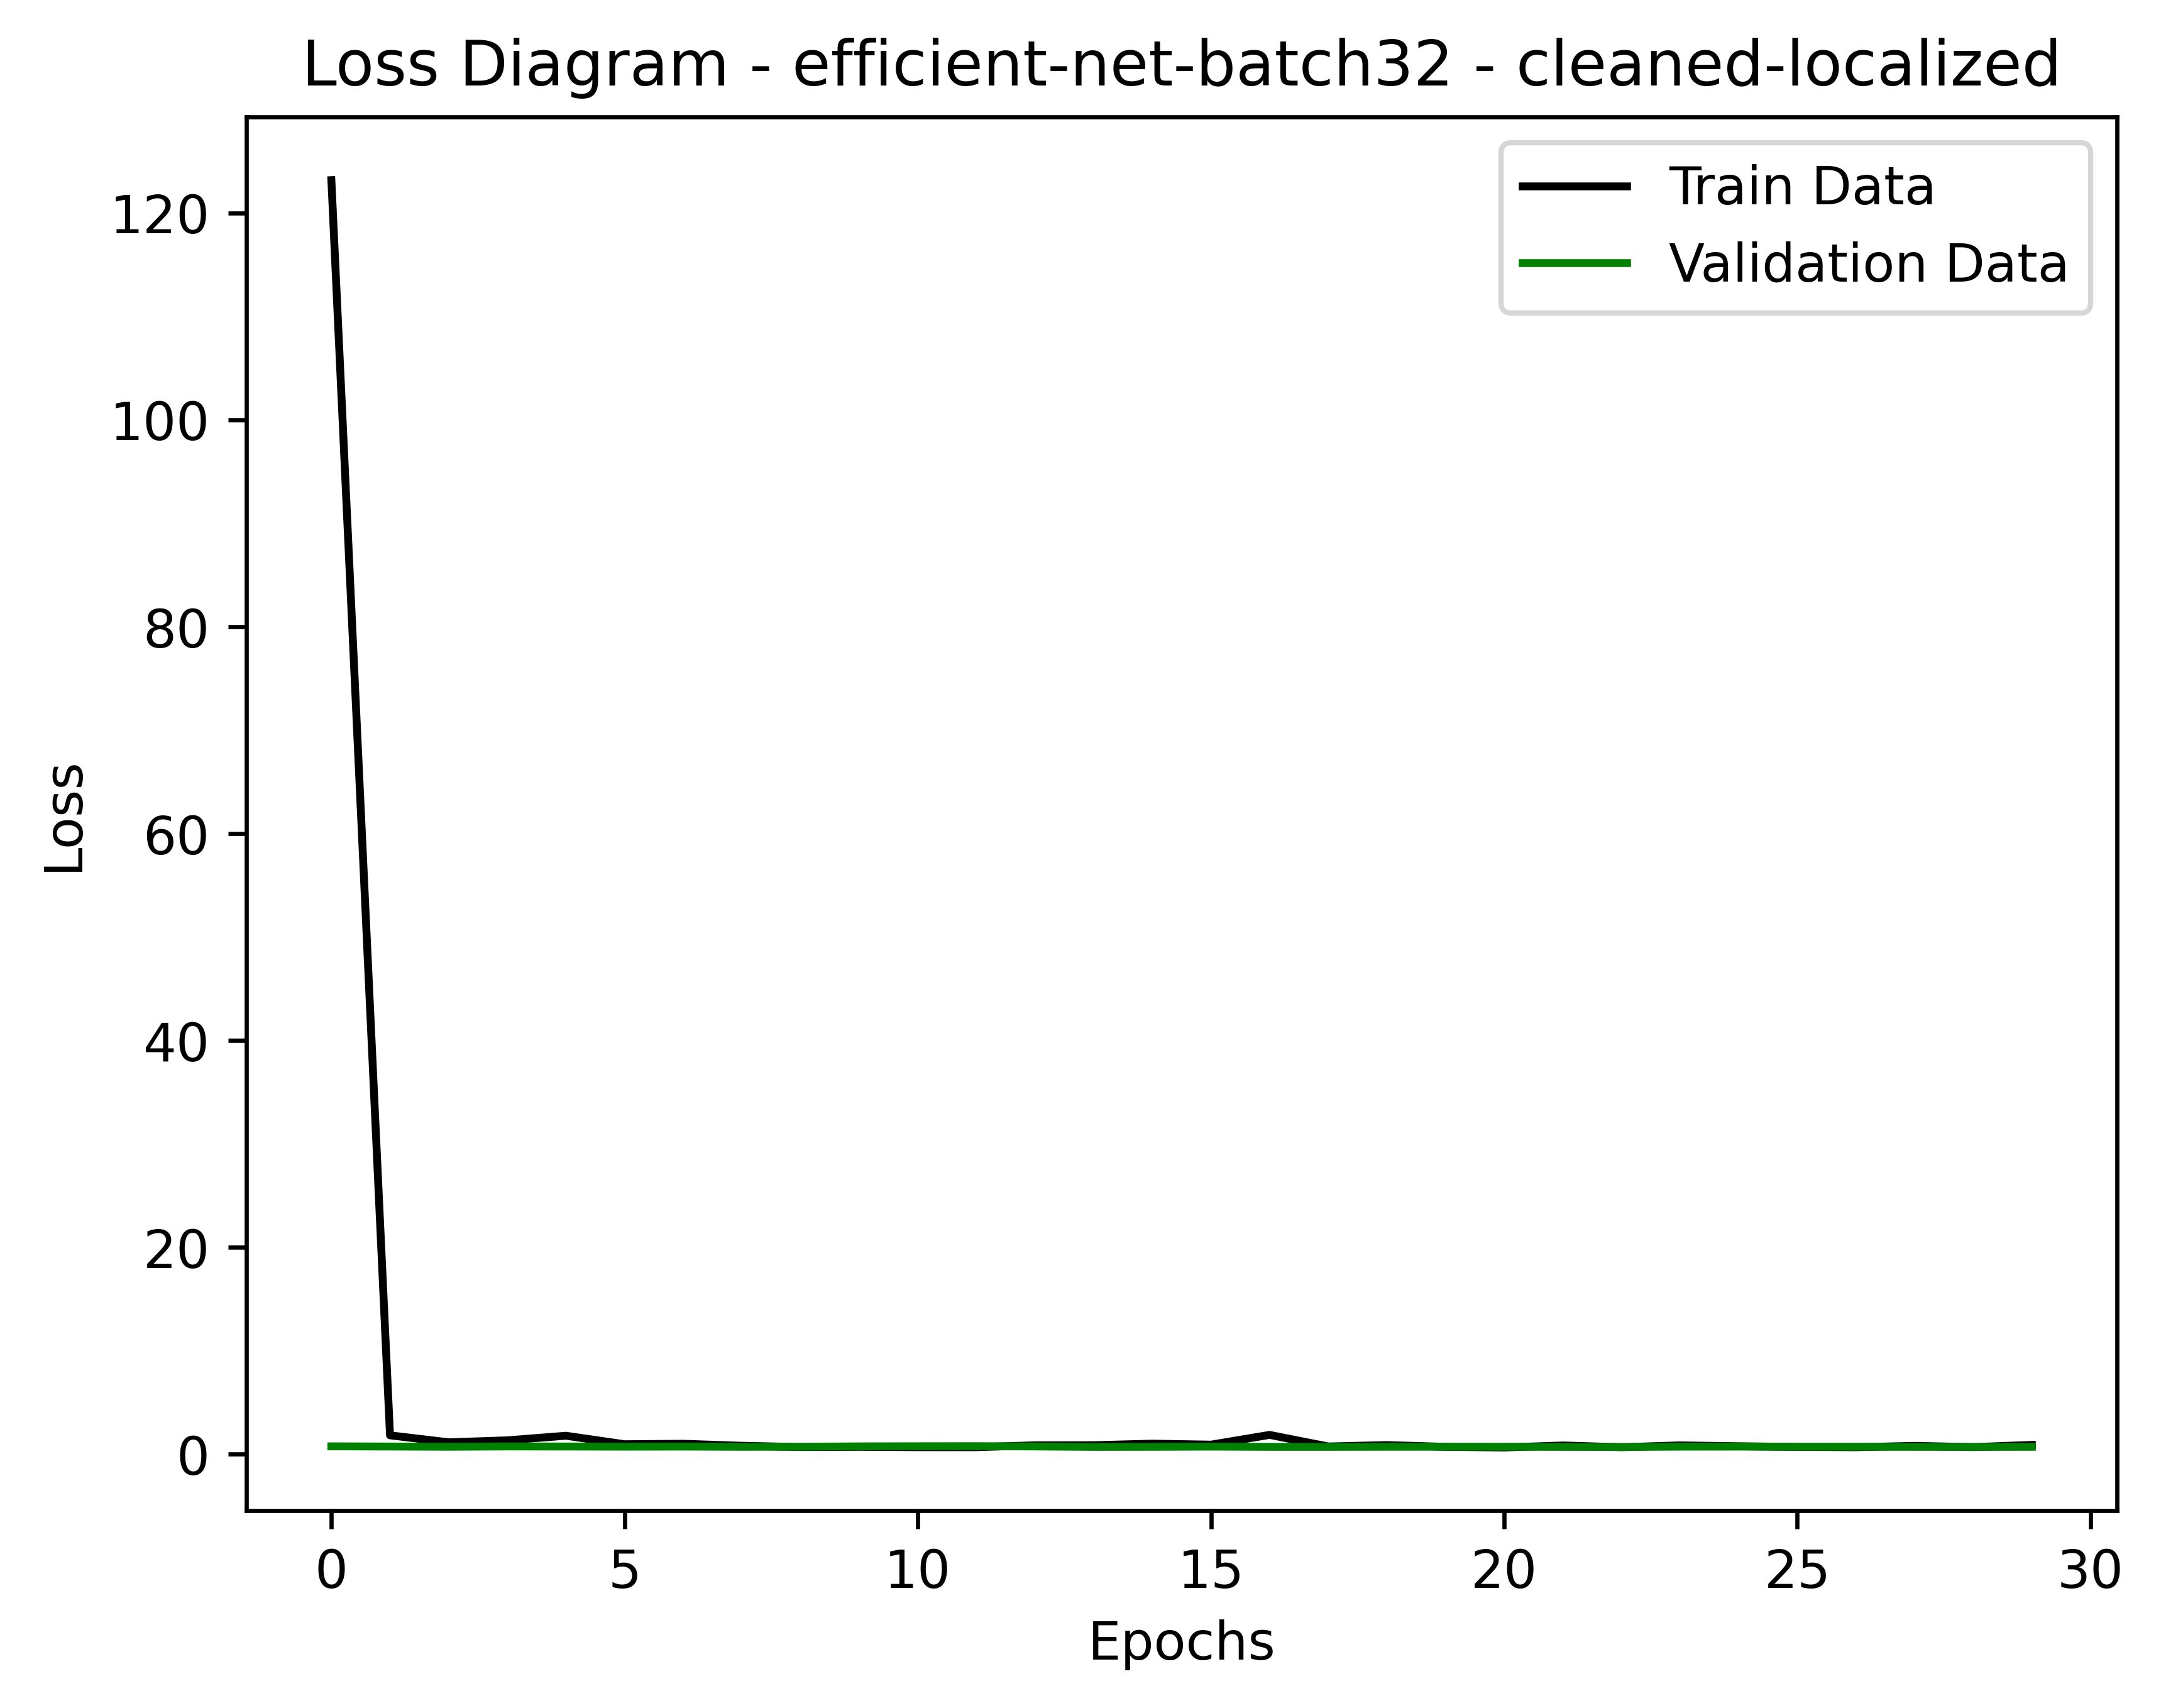

In [13]:
def NetPlot(net_histories,n_epch):
    import numpy as np
    import matplotlib.pyplot as plt

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in net_histories:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['categorical_accuracy']
        val_accuracy=history['val_categorical_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)


    losses2=np.zeros((1,n_epch))
    val_losses2=np.zeros((1,n_epch))
    accuracies2=np.zeros((1,n_epch))
    val_accuracies2=np.zeros((1,n_epch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i

    for i in accuracies:
        accuracies2+=i

    for i in val_accuracies:
        val_accuracies2+=i
        
    N_SPLITS = 5

    # 10 is number of folds
    losses2=(losses2/N_SPLITS).flatten()
    accuracies2=(accuracies2/N_SPLITS).flatten()
    val_losses2=(val_losses2/N_SPLITS).flatten()
    val_accuracies2=(val_accuracies2/N_SPLITS).flatten()
    
    # print('\nAccuracies: '+ str(accuracies2) +'\nLosses: '+ str(losses2))

    plt.figure('Accracy Diagram',dpi=600)
    plt.title(f'Accracy Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Accuracy-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.title(f'Loss Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Loss-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')
    
NetPlot(lst_history,N_EPOCHS)

In [14]:
# Zipando pasta com resultados
import zipfile

def compactar_pasta(pasta, nome_arquivo_zip):
    with zipfile.ZipFile(nome_arquivo_zip, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, _, files in os.walk(pasta):
            for arquivo in files:
                caminho_completo = os.path.join(root, arquivo)
                zip_file.write(caminho_completo, os.path.relpath(caminho_completo, pasta))

nome_arquivo_zip = f'{VERSION}-results.zip'
compactar_pasta(RESULTS_PATH, nome_arquivo_zip)